---
title: "Overparameterization and Double Descent"
author: "Yahya Rahhawi"
date: "2025-05-10"
categories: [Machine Learning, Implementation, Optimization]
format:
  html:
    toc: true
    code-fold: false
---

## Abstract
In this project, we explore the phenomenon of double descent in overparameterized linear regression models. Using a custom feature mapping approach inspired by kernel methods, we transform 1-dimensional data into a higher-dimensional space using random feature projections. This overparameterization allows the model to capture complex, nonlinear patterns but also introduces the risk of overfitting when the number of features exceeds the number of data points. We observe that the test error initially decreases as the model gains capacity, spikes sharply around the interpolation threshold, and then decreases again as the model becomes significantly overparameterized. This counterintuitive behavior highlights the unique generalization properties of modern machine learning models and provides insights into why deep networks can perform well despite their extreme parameter counts. You can see my implementation of the closed-form linear regression at [this GitHub link](https://github.com/yahyarahhawi/yahyarahhawi.github.io/blob/main/posts/Double%20Descent/linear.py).

In [2]:
%load_ext autoreload
%autoreload 2
from linear import MyLinearRegression, OverParameterizedLinearRegressionOptimizer
import numpy as np
import matplotlib.pyplot as plt

## Setup 
This cell defines the RandomFeatures class for generating random nonlinear feature maps, which is adapted from Professor Chodrow’s notes. The RandomFeatures class constructs high-dimensional representations of input data using random weight vectors and bias terms, with customizable activation functions. This is a crucial step in implementing overparameterized linear regression, allowing the model to capture complex, nonlinear relationships in the data. The default activation function is the logistic sigmoid, but it can be replaced with other functions, such as the square function, for experimentation with different feature mappings.

In [3]:
import torch
import torch.nn as nn

def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

### The Breakdown of the Normal Equation When \(p > n\)

When optimizing a linear regression model to minimize the mean-squared error loss, we often use the closed-form solution for the optimal weights:

$$
\hat{w} = (X^\top X)^{-1} X^\top y
$$

The issue lies in the matrix $X$, particularly its invertibility. When the number of features $p$ exceeds the number of data points $n$, the matrix $X$ must have linearly dependent columns. As a result, the operation $X^\top X$ becomes undefined in the context of matrix inversion because $X^\top X$ is not invertible. Therefore, the normal equation cannot be used when $p > n$. We will solve this issue by introducing the pseudoinverse. The pseudoinverse, specifically the Moore-Penrose pseudoinverse, extends the concept of matrix inversion to singular or non-square matrices, providing a stable solution for least-squares problems when p > n.

### Testing Linear Regression on Random Features

To test the linear regression I implemented in linear.py, I will first generate my data. my data points are sampled from the function $f(x) = x^4$ with normal noise added to it

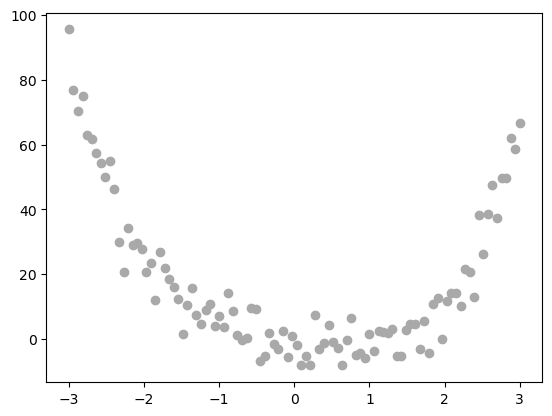

In [4]:
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

plt.scatter(X, y, color='darkgrey', label='Data')

Now, let’s fit our linear regression model on 150 random features generated from our 2D data. This setup intentionally overparameterizes the model, with the number of features p = 150 exceeding the number of data points n = 100. This allows us to observe the effects of overparameterization and potential overfitting.

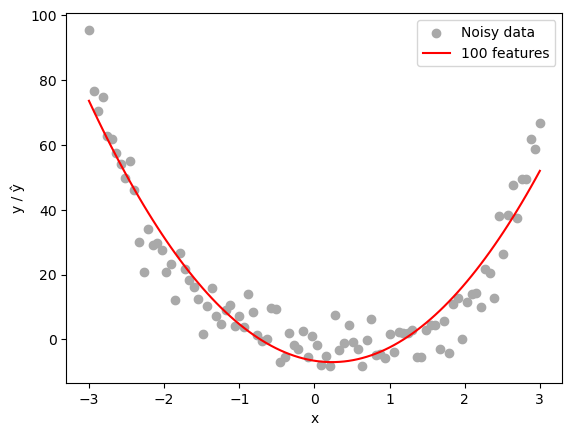

Train MSE: 56.75595760061362


In [5]:

import numpy as np
import matplotlib.pyplot as plt

# 1) Create a feature map (try p > n to see overparameterization)
n_features = 100
phi = RandomFeatures(n_features=n_features, activation=square)
phi.fit(X)                               
X_feat = phi.transform(X)                

# 2) Instantiate your regression model and optimizer
model = MyLinearRegression()
opt   = OverParameterizedLinearRegressionOptimizer(model)

# 3) Fit closed‑form and predict
opt.fit(X_feat, y.squeeze())             # y has shape (100, 1) so we squeeze to (100,)
y_pred = model.predict(X_feat)           # continuous predictions

# 4) Plot data vs. learned curve
plt.scatter(X.numpy(), y.numpy(), color='darkgrey', label='Noisy data')
plt.plot(X.numpy(), y_pred.detach().numpy(), color='red', label=f'{n_features} features')
plt.xlabel('x'); plt.ylabel('y / ŷ')
plt.legend(); plt.show()

# 5) Print training MSE
print("Train MSE:", model.loss(X_feat, y.squeeze()).item())

We notice that the model did quite well at generalizing the pattern seen in the data, even when the number of features exceeds the number of data points.

## More Complex Pattern: Number of Corruption Artifacts in Images

Let's now have a look at our random features being applied to corrupted images. Then, we will compare model performance across various range of parameter numbers. This will help us further inpect the effect of adding more features to training loss and testing loss.

Let's begin by loading an sample image from sklearn datasets

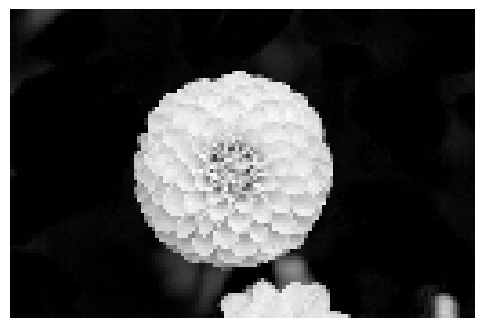

In [6]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = 255 - X 
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower, cmap = 'gray')
off = ax.axis("off")

Now, let's corrupt the image by adding a number of corruption artifacts to the image. The corruption artifacts are grey squares added to the image, and we will try to predict the number of artifacts added to the image. I am using the function corrupted_image borrowed from professor Chodrow's notes.

In [7]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

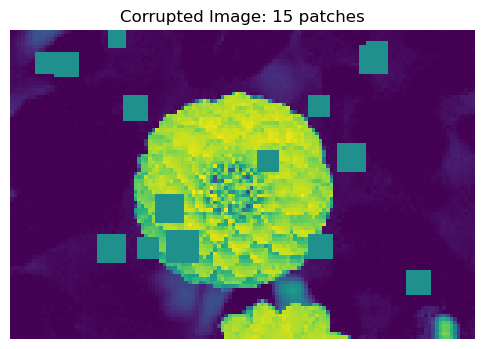

In [11]:
X, y = corrupted_image(flower, mean_patches = 20)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1)
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

Now that we have an example of what a corrupted image looks like, let's generate a lot of them! the label will be the actual number of squares added to the image

In [12]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

Now, let's generate our train_test sets. a test size of 0.5 is good to observe the difference in test loss and train loss in our experiment

In [13]:
from sklearn.model_selection import train_test_split
X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Now let's train! I am training the model on different number of parameters, starting from 0 to 300, and plotting both the train loss and test loss

In [15]:
n_features = range(1,301)

train_losses = []
test_losses = []

for n in n_features:
    phi = RandomFeatures(n_features=n, activation=square)
    phi.fit(X_train)                               # fit once on the training inputs
    X_train_feat = phi.transform(X_train)                # shape (100, 150)
    X_test_feat = phi.transform(X_test)                # shape (100, 150)

    model = MyLinearRegression()
    opt   = OverParameterizedLinearRegressionOptimizer(model)

    opt.fit(X_train_feat, y_train.squeeze())             # y has shape (100, 1) so we squeeze to (100,)
    y_pred = model.predict(X_test_feat)           # continuous predictions
    train_losses.append(model.loss(X_train_feat, y_train.squeeze()).item())
    test_losses.append(model.loss(X_test_feat, y_test.squeeze()).item())
    if n % 20 == 0:
        print(f"n_features: {n}, train_loss: {train_losses[-1]}, test_loss: {test_losses[-1]}")



n_features: 20, train_loss: 214.82480112861558, test_loss: 373.14158273374034
n_features: 40, train_loss: 64.72116250014501, test_loss: 371.55640846843016
n_features: 60, train_loss: 43.31662865830799, test_loss: 721.765908299188
n_features: 80, train_loss: 16.224967757212333, test_loss: 438.8784872753655
n_features: 100, train_loss: 2.3784471836775594e-25, test_loss: 36143.203253335094
n_features: 120, train_loss: 5.420234880780984e-26, test_loss: 362.8509767192916
n_features: 140, train_loss: 5.0462832572700156e-26, test_loss: 384.94344826167645
n_features: 160, train_loss: 1.0385231938224764e-24, test_loss: 199.83423095735074
n_features: 180, train_loss: 6.964458501743703e-27, test_loss: 204.90400198784667
n_features: 200, train_loss: 1.0979220632636642e-26, test_loss: 163.11367772090244
n_features: 220, train_loss: 1.468149030706825e-26, test_loss: 159.60466066122575
n_features: 240, train_loss: 1.0028072091758801e-24, test_loss: 196.50770974516294
n_features: 260, train_loss: 2.76

Now let's plot our results! I am using logs to better visualize the loss changes over different magnitudes.

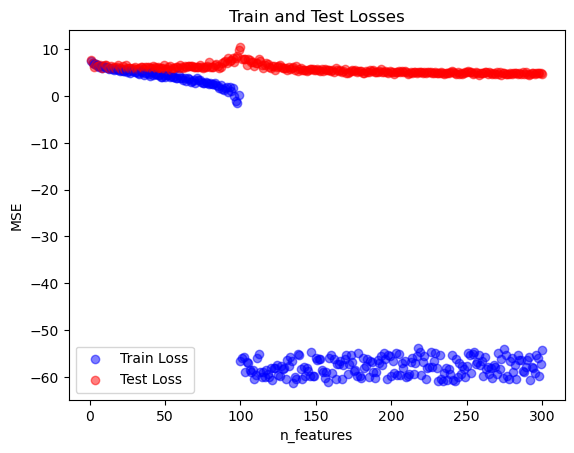

In [16]:
for i, n in enumerate(n_features):
    plt.scatter(n, np.log(train_losses[i]), color = 'blue', alpha = .5)
    plt.scatter(n, np.log(test_losses[i]), color = 'red', alpha = .5)

plt.xlabel('n_features')
plt.ylabel('MSE')
plt.title('Train and Test Losses')
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

Interesting results! The plot illustrates the double descent phenomenon, where the test error initially decreases as the model gains more features, then spikes sharply around the interpolation threshold when the number of features matches the number of training samples. After this peak, the test error decreases again in the overparameterized region, where the model has enough capacity to capture complex patterns despite fitting the training data perfectly. This second descent reflects the  ability of highly overparameterized models to generalize well even though being classically overfitted.

In [55]:
# n_features with the lowest test loss
best_n = n_features[np.argmin(test_losses)]
print(f"Best n_features: {best_n}, test_loss: {min(test_losses)}")

Best n_features: 291, test_loss: 75.86592287468265


We see as well that the best loss is when n_features is 291, which is way beyond the threshold of n = 100 

## Discussion
Through this exploration, we observed the double descent phenomenon, where test error initially decreases as the model’s capacity increases, then spikes near the interpolation threshold, and eventually decreases again as the model becomes significantly overparameterized. This behavior challenges the classical view that overfitting is always detrimental to generalization. Instead, we see that sufficiently large models can recover from this high-error region and achieve strong generalization, even when the number of features far exceeds the number of training samples. This suggests that overparameterized models, such as deep neural networks, can exploit their massive capacity to fit complex, real-world data without overfitting in the traditional sense.